In [ ]:
import torch 
import torch.nn as nn
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import torch.optim as optim

In [ ]:
class config:
    device = "cuda" if torch.cuda.is_available else "cpu"
    """
[filters,kernel_size,stride,padding]
"""
    yolo_config = [
        (64,7,2,3),
        "MaxPool",
        (192,3,1,1),
        "MaxPool",
        (128,1,1,0),
        (256,3,1,1),
        (256,1,1,0),
        (512,3,1,1),
        "MaxPool",
        [(256,1,1,0), (512,3,1,1),4],
        (512,1,1,0),
        (1024,3,1,1),
        "MaxPool",
        [(512,1,1,0), (1024,3,1,1),2],
        (1024,3,1,1),
        (1024,3,2,1),
        (1024,3,1,1),
        (1024,3,1,1),
    ]
    batch_size = 32
    learning_rate = 5e-5
    epochs = [50,50,50]

In [ ]:
pd.read_csv('../input/pascalvoc-yolo/train.csv')

# UTILS

In [ ]:
def plot_image(image,box):
    f,ax = plt.subplots(1)
    ax.imshow(image)
    size = image.shape[0]
    window = box.shape[0]
    y_obj,x_obj = torch.where(box[:,:,20]==1)
    for k in range(len(y_obj)):
        i,j = y_obj[k].item(),x_obj[k].item()
        cell = box[i][j]
        xc = size * (j+cell[21])/window
        yc = size * (i+cell[22])/window
        width = size * cell[23]
        height = size * cell[24]
        rect = patches.Rectangle((xc-width/2,yc-height/2),width,height,linewidth=2,
                edgecolor="r",
                facecolor="none")
        ax.add_patch(rect)
        ax.text(xc,yc,'boy')

def calc_iou(b_pred,b_true,img_size):
    box1_x1 = b_pred[..., 0:1] - b_pred[..., 2:3]*img_size/ 2
    box1_y1 = b_pred[..., 1:2] - b_pred[..., 3:4]*img_size/ 2
    box1_x2 = b_pred[..., 0:1] + b_pred[..., 2:3]*img_size/ 2
    box1_y2 = b_pred[..., 1:2] + b_pred[..., 3:4]*img_size/ 2
    box2_x1 = b_true[..., 0:1] - b_true[..., 2:3]*img_size/ 2
    box2_y1 = b_true[..., 1:2] - b_true[..., 3:4]*img_size/ 2
    box2_x2 = b_true[..., 0:1] + b_true[..., 2:3]*img_size/ 2
    box2_y2 = b_true[..., 1:2] + b_true[..., 3:4]*img_size/ 2 
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def non_max_supression(bboxes,iou_threshold,img_size):
    """
    accepts [class_pred,obj_prob,x1,y1,width,height] as input
    """
    # Remove bboxes with object pred less than some threshold
    #bboxes = [b for b in bboxes if b[1] > threshold]
    # Sort bboxes in descending order of obj_pred
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    # Store bboxes after nms in a list
    bboxes_nms = []
    
    while bboxes:
        # Select box with highest obj_pred initially
        box = bboxes.pop(0)
        bboxes = [
            b for b in bboxes
            if b[3] != box[4] #keep the subsequent box if the class predictions are diiferent
            or calc_iou(
            b[...,5:],box[...,5:],img_size # or keep the box if the iou of two boxes of same class is less than some threshold
            ) < iou_threshold 
        ]
        bboxes_nms.append(box)
    
    return bboxes_nms

# Model Architecture

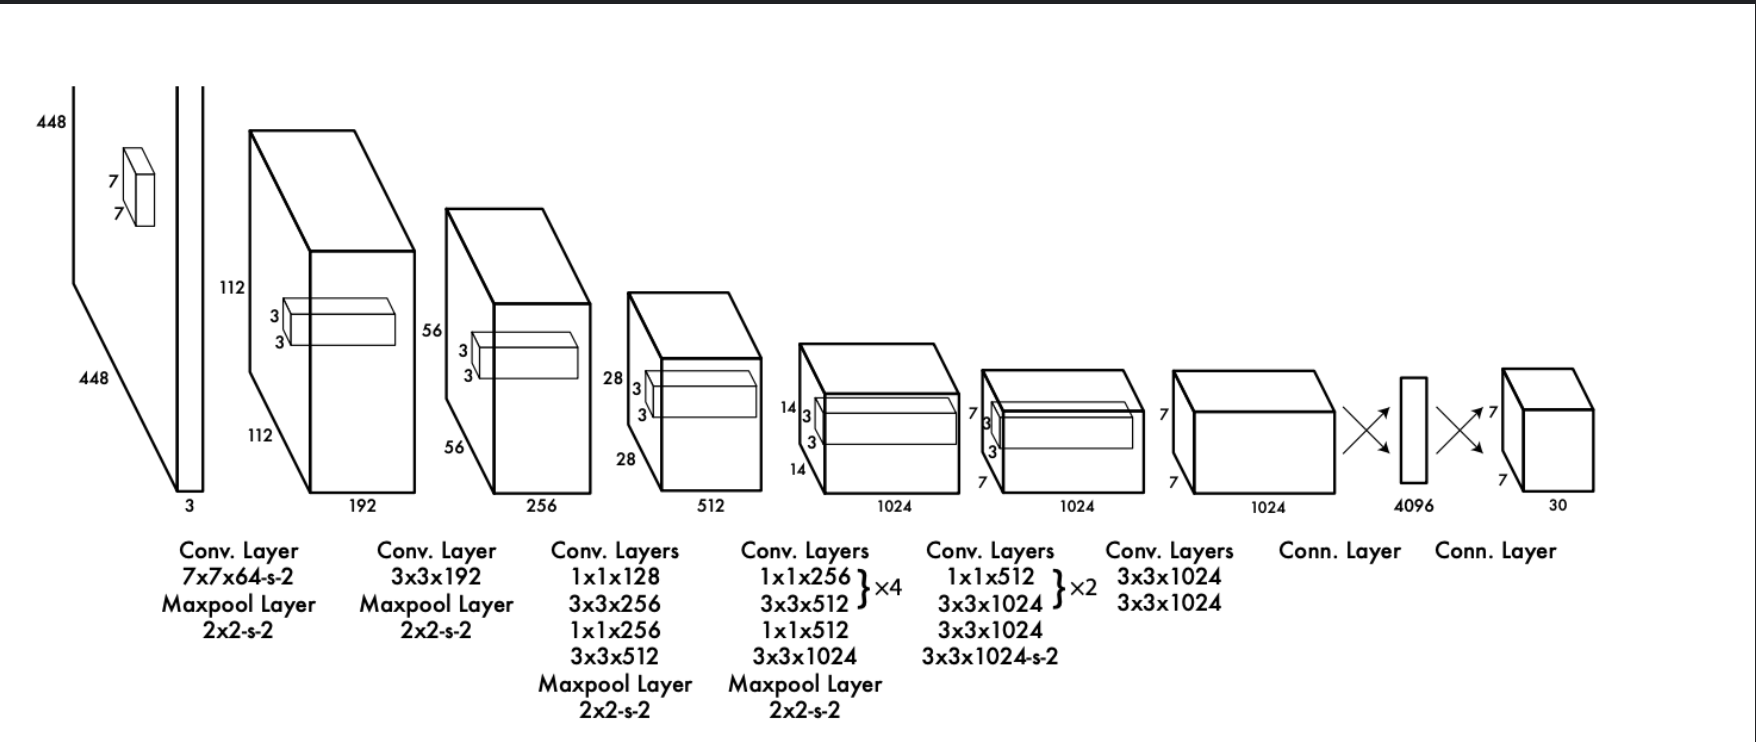

In [ ]:
class conv_block(nn.Module):
    def __init__(self,activation_func,**kwargs):
        super(conv_block,self).__init__()
        self.conv = nn.Conv2d(**kwargs)
        self.batch_norm = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation = activation_func
        
    def forward(self,x):
        return self.activation(self.batch_norm(self.conv(x)))

class yolo(nn.Module):
    def __init__(self,config,img_channels,activation_func,window_size,n_boxes,n_classes,fcn_units):
        super(yolo,self).__init__()
        #self.config = config
        self.img_channels = img_channels
        self.activation_func = activation_func
        self.fcn_inp_channels = None
        self.conv_layers = self.init_conv_layers(config)
        self.fcn_layers = self.init_fcn_layers(window_size,n_boxes,n_classes,fcn_units)
    
    def forward(self,x):
        return self.fcn_layers(torch.flatten(self.conv_layers(x),start_dim=1)) #start_dim =1 as dim=0 is n_batches
    
    def init_conv_layers(self,config):
        layers = []
        inp_channels = self.img_channels #Initializing input channels
        for x in config:
            if x == 'MaxPool':
                layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
            elif type(x) == tuple:
                params = {'in_channels':inp_channels, 'out_channels':x[0],
                          'kernel_size':x[1],'stride':x[2],'padding':x[3]}
                layers.append(conv_block(self.activation_func,**params))
                inp_channels = x[0]
            elif type(x) == list:
                num_reps = x[-1]
                for i in range(num_reps):
                    for layer in x[:-1]:
                        print(layer)
                        params = {'in_channels':inp_channels, 'out_channels':layer[0],
                          'kernel_size':layer[1],'stride':layer[2],'padding':layer[3]}
                        layers.append(conv_block(self.activation_func,**params))
                        inp_channels = layer[0]
            self.fcn_inp_channels = inp_channels
        return nn.Sequential(*layers)
    
    def init_fcn_layers(self,window_size,n_boxes,n_classes,fcn_units):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fcn_inp_channels*window_size*window_size,fcn_units),
            self.activation_func,
            nn.Linear(fcn_units,window_size*window_size*(n_classes+n_boxes*5))
        )
        

# Yolo loss

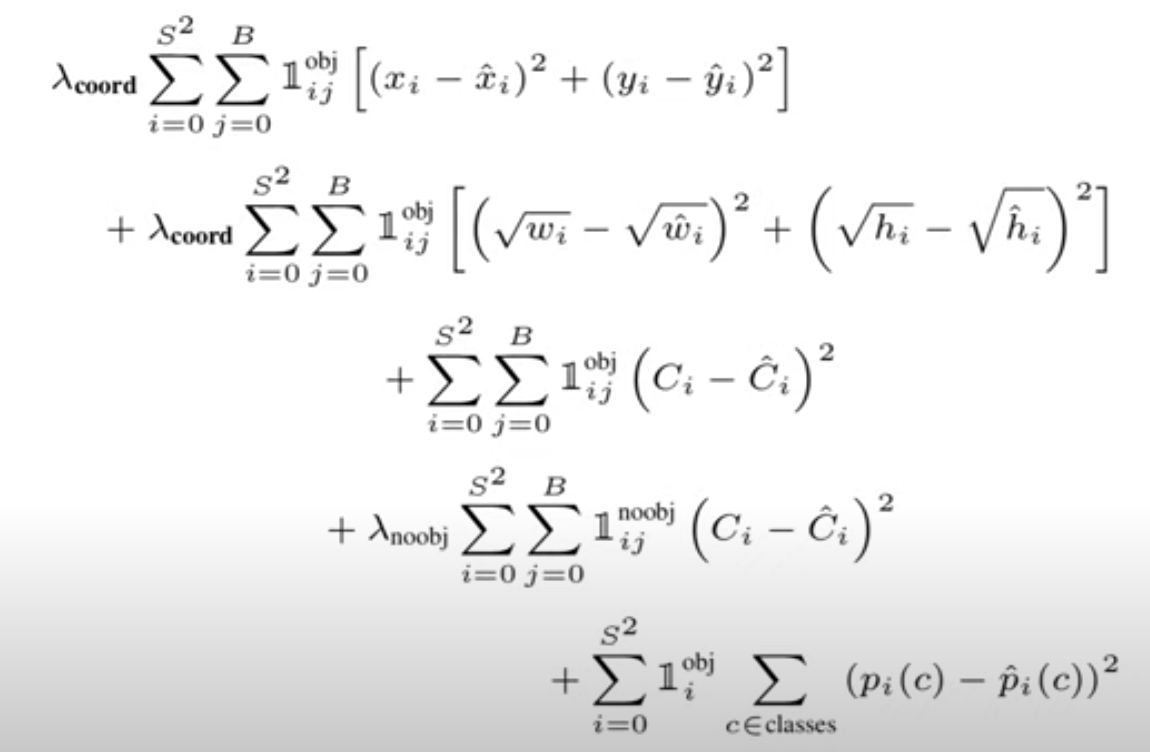

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self,img_size,window_size,n_boxes,n_classes,obj_loss_wt,nobj_loss_wt):
        super(YoloLoss,self).__init__()
        self.mse =  nn.MSELoss(reduction='sum')
        self.img_size = img_size
        self.s = window_size
        self.b = n_boxes
        self.c = n_classes
        self.obj_loss_wt = obj_loss_wt
        self.nobj_loss_wt = nobj_loss_wt
    
    def forward(self, y_pred, y_true):
        y_pred = y_pred.reshape(-1,self.s,self.s,self.c+self.b*5)
        y_pred = torch.nan_to_num(y_pred,0)
        y_true = torch.nan_to_num(y_true,0)
        box_list = []
        start_index = self.c + 1
        end_index = self.c + 5 #21:25,26:30, 
        for box in range(self.b):
            iou = calc_iou(y_pred[...,start_index:end_index],y_true[...,self.c+1:self.c+5],self.img_size) #shape = (batch,s,s,1)
            start_index = end_index + 1
            end_index = end_index + 5
            box_list.append(iou.unsqueeze(0))
            #iou_b2 = calc_iou(y_pred[...,self.c+5:self.c+10],y_true[...,self.c+1:self.c+5])#shape = (batch,s,s,1)
        """
        Next, we need to concatenate iou_b1 and iou_b2. But we'll first unsqueeze them to add extra dim as
        the two sets are different
        """
        ious = torch.cat(box_list,dim=0) #(2,batch,s,s,1)
        """
        To select boxes with max iou, we'll do a torch max at dim 0. This way, for each location of each input in
        batch, we'll get only one of the two bounding boxes
        """
        max_iou,bbox = torch.max(ious,dim=0) #bbox shape (batch,s,s,1)
        identity_obj_f = y_true[...,self.c:self.c+1]
        
        """
        BOX COORDINATE LOSS - y_pred[...,21:25]/y_pred[...,25:30] => shape = (batch,s,s,4)
        bbox will return a 0,1 values based on which box has the maximum iou. We'll consider only the best box 
        for computing loss. We'll multiply the bbox with y_pred coordinates. This way, only the best bounding box
        at each cell will be considered. Note y_pred[...,21:25] are predicted coordinates for first bounding box
        """
        
        bbox_coordinates = bbox * y_pred[...,26:30] + (1-bbox) * y_pred[...,21:25]
        # Multiply this with identity_obj_f to compute only when object is present in reality
        bbox_preds = identity_obj_f * bbox_coordinates
        bbox_targets = identity_obj_f * y_true[...,21:25]
        # square root for width and height
        bbox_preds[...,2:4] = torch.sign(bbox_preds[..., 2:4]) * torch.sqrt(torch.abs(bbox_preds[...,2:4]+1e-6))
        bbox_targets[...,2:4] = torch.sqrt(bbox_targets[...,2:4])
        # Flatten all examples to calculate mse
        coordinates_loss = self.mse(torch.flatten(bbox_preds,end_dim=2),
                                   torch.flatten(bbox_targets,end_dim=2))
        """
        OBJECT LOSS - y_pred[...,20:21]/y_pred[...,25:26]
        Compute loss related to existence of object
        """
        obj_exist_loss = bbox * y_pred[...,25:26] + (1-bbox) * y_pred[...,20:21]
        obj_exist_loss = identity_obj_f * obj_exist_loss
        obj_exist_loss = self.mse(torch.flatten(obj_exist_loss,end_dim=2),
                                 torch.flatten(identity_obj_f * y_true[...,20:21],end_dim=2))
        """
        No object loss, mse score at locations where object is not present
        """
        identity_no_obj_f = 1 - identity_obj_f
        no_obj_loss = self.mse(
            torch.flatten(identity_no_obj_f * y_pred[...,20:21],end_dim=2),
            torch.flatten(identity_no_obj_f * y_true[...,20:21],end_dim=2)
        )
        no_obj_loss += self.mse(
            torch.flatten(identity_no_obj_f * y_pred[...,25:26],end_dim=2),
            torch.flatten(identity_no_obj_f * y_true[...,20:21],end_dim=2)
        )
        """
        Class Loss
        """
        class_loss = self.mse(
        torch.flatten(identity_obj_f * y_pred[...,:20],end_dim=2),
        torch.flatten(identity_obj_f * y_true[...,:20],end_dim=2 )
        )
        loss = self.obj_loss_wt * coordinates_loss + obj_exist_loss + self.nobj_loss_wt * no_obj_loss + class_loss
        return loss

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,csv,num_images,img_dir,box_dir,img_size,s=7,b=2,c=20):
        self.csv = pd.read_csv(csv,header=None)
        self.csv = self.csv.head(num_images)
        self.img_dir = img_dir
        self.box_dir = box_dir
        self.img_size = img_size
        self.s = s
        self.b = b
        self.c = c
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.img_dir, self.csv.loc[index, 0])
        image = Image.open(img_path)
        transform = T.Compose([T.Resize((self.img_size,self.img_size))])
        transform = T.Resize((self.img_size,self.img_size))
        image = transform(image)
        transform = T.ToTensor()
        image = transform(image)
        #image = image.permute([1,2,0])
        box_path = os.path.join(self.box_dir, self.csv.loc[index, 1])
        box_tensor = torch.zeros((self.s, self.s, self.c + 5))
        with open(box_path) as f:
            for label in f.readlines():
                """
                x,y,width,height is relative to entire image
                we first need to find the window with xc and yc
                i,j = int(self.s * y) and int(self.s * x)
                and then find x and y relative to that window
                x = self.s * x - j, self.s * y - i
                """
                class_, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                class_ = int(class_)
                i,j = int(self.s * y), int(self.s * x)
                x,y = self.s * x - j, self.s * y - i
                #width,height = self.s * width, self.s * height
                """
                width and height are relative to image
                """
                box_tensor[i,j,20] = 1
                box_tensor[i,j,21:25] = torch.tensor([x,y,width,height])
                box_tensor[i,j,class_] = 1

        return image, box_tensor

In [ ]:
train_dataset = Dataset(
        "../input/pascalvoc-yolo/train.csv",
    2000,
    "../input/pascalvoc-yolo/images",
    '../input/pascalvoc-yolo/labels',
    448
    )
train = DataLoader(
        dataset=train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=True
    )

In [ ]:
def train_epoch(train_loader,model,optimizer,loss_fn):
    loss_sum = 0
    count = 0
    for batch in train_loader:
        x = batch[0]
        y = batch[1]
        x, y = x.to(config.device), y.to(config.device)
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        loss_sum+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1
    print(f"epoch mean loss {loss_sum/count}")
    l = loss_sum/count
    return l

In [ ]:
loss_fn = YoloLoss(448,7,2,20,1,1)
model = yolo(config.yolo_config,3,nn.LeakyReLU(0.1),7,2,20,496).to(config.device)

In [ ]:
min_=200
optimizer = optim.Adam(
        model.parameters(), lr=config.learning_rate
    )
for epoch in range(config.epochs[0]):
    print(f"epoch:{epoch}")
    l = train_epoch(train,model,optimizer,loss_fn)
    if l < min_:
        min_ = l
        checkpoint = {'model': model,
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, 'checkpoint.pth')
        print('Model Saved')

In [ ]:
optimizer = optim.Adam(
        model.parameters(), lr=1e-5#config.learning_rate
    )
for epoch in range(config.epochs[1]):
    print(f"epoch:{epoch}")
    l = train_epoch(train,model,optimizer,loss_fn)
    if l < min_:
        min_ = l
        checkpoint = {'model': model,
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, 'checkpoint.pth')
        print('Model Saved')

In [ ]:
optimizer = optim.Adam(
        model.parameters(), lr=5e-6#config.learning_rate
    )
for epoch in range(config.epochs[2]):
    print(f"epoch:{epoch}")
    l = train_epoch(train,model,optimizer,loss_fn)
    if l < min_:
        min_ = l
        checkpoint = {'model': model,
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, 'checkpoint.pth')
        print('Model Saved')